In [1]:
%matplotlib inline
%load_ext Cython
%load_ext wurlitzer
%load_ext heat

import h10
import matplotlib.pyplot as plt
import numpy as np
import boost_histogram as bh
import functools
import operator

from tqdm import tqdm

from ROOT import TH1D, TH2D

def good_event(event):
    if event.dc_sect.size == 0 or event.dc_vz.size == 0:
        return False
    if event.p.size == 0:
        return False
    
    return True
    

Welcome to JupyROOT 6.22/07


In [2]:
root_reader = h10.h10_data()
#root_reader.add("/Volumes/LaCiE/physics/e1d/v2/empty/*.root")
root_reader.add("/Users/tylern/Data/e1d/test/*.root")

# empty_target = h10.h10_data()
# empty_target.add("/Volumes/LaCiE/physics/e1d/v2/empty/*.root")

# root_reader = h10.h10_mc()
# root_reader.add("/Users/tylern/Data/e1d/sim/e1d_osg_4065835_144*.root")

print(root_reader.num_entries)

1600121


1600122it [20:45, 1284.97it/s]                             
/usr/local/lib/python3.8/site-packages/pyheat/pyheat.py:158: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_yticklabels(row_labels, minor=False)


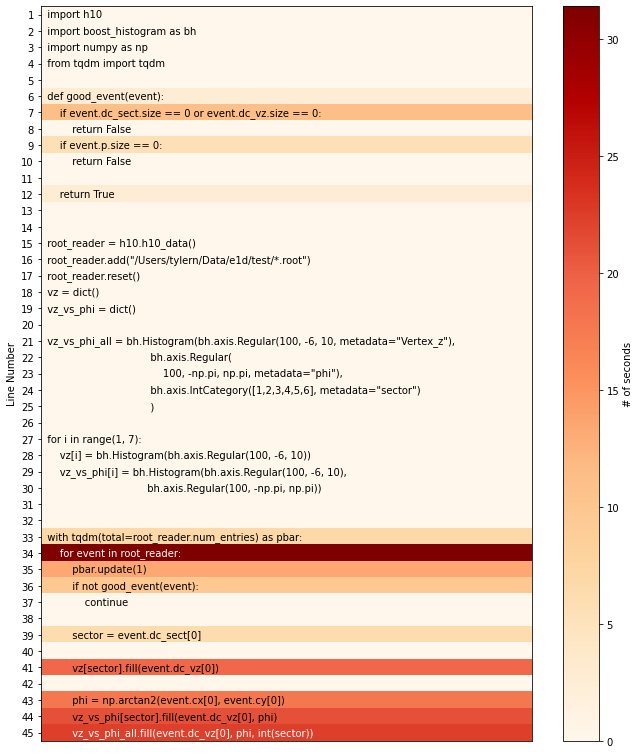

In [8]:
%%heat
import h10
import boost_histogram as bh
import numpy as np
from tqdm import tqdm

def good_event(event):
    if event.dc_sect.size == 0 or event.dc_vz.size == 0:
        return False
    if event.p.size == 0:
        return False
    
    return True
    

root_reader = h10.h10_data()
root_reader.add("/Users/tylern/Data/e1d/test/*.root")
root_reader.reset()
vz = dict()
vz_vs_phi = dict()

vz_vs_phi_all = bh.Histogram(bh.axis.Regular(100, -6, 10, metadata="Vertex_z"),
                                 bh.axis.Regular(
                                     100, -np.pi, np.pi, metadata="phi"),
                                 bh.axis.IntCategory([1,2,3,4,5,6], metadata="sector")
                                 )

for i in range(1, 7):
    vz[i] = bh.Histogram(bh.axis.Regular(100, -6, 10))
    vz_vs_phi[i] = bh.Histogram(bh.axis.Regular(100, -6, 10), 
                                bh.axis.Regular(100, -np.pi, np.pi))


with tqdm(total=root_reader.num_entries) as pbar:
    for event in root_reader:
        pbar.update(1)
        if not good_event(event):
            continue

        sector = event.dc_sect[0]
        
        vz[sector].fill(event.dc_vz[0])

        phi = np.arctan2(event.cx[0], event.cy[0])
        vz_vs_phi[sector].fill(event.dc_vz[0], phi)
        vz_vs_phi_all.fill(event.dc_vz[0], phi, int(sector))


In [9]:
with tqdm(total=root_reader.num_entries) as pbar:
    for event in root_reader:
        pbar.update(1)

1600122it [00:22, 69942.49it/s]                             


In [ ]:
%%time
root_reader.reset()
vz = dict()
vz_vs_phi = dict()


for i in range(1, 7):
    vz[i] = bh.Histogram(bh.axis.Regular(100, -6, 10))
    vz_vs_phi[i] = bh.Histogram(bh.axis.Regular(100, -6, 10), 
                                bh.axis.Regular(100, -np.pi, np.pi))


with tqdm(total=root_reader.num_entries) as pbar:
    for event in root_reader:
        pbar.update(1)
        if not good_event(event):
            continue

        sector = event.dc_sect[0]
        _vz = event.dc_vz[0]
        
        vz[sector].fill(_vz)

        phi = np.arctan2(event.cx[0], event.cy[0])
        vz_vs_phi[sector].fill(_vz, phi)
        

In [ ]:
%%time
root_reader.reset()
vz = dict()
vz_vs_phi = dict()


for i in range(1, 7):
    vz[i] = TH1D(f"vz_{i}",f"vz_{i}",100, -6, 10)
    vz_vs_phi[i] = TH2D(f"vz_vs_phi_{i}",f"vz_vs_phi_{i}",100, -6, 10, 100, -np.pi, np.pi)


with tqdm(total=root_reader.num_entries) as pbar:
    for event in root_reader:
        pbar.update(1)
        if not good_event(event):
            continue

        sector = event.dc_sect[0]
        _vz = event.dc_vz[0]
        
        vz[sector].Fill(_vz)

        phi = np.arctan2(event.cx[0], event.cy[0])
        vz_vs_phi[sector].Fill(_vz, phi)
       

In [ ]:
fig, ax = plt.subplots(figsize=[12,9])
total = bh.Histogram(bh.axis.Regular(100, -6, 10))
for i in range(1, 7):
    total = total + vz[i]
    y, x = vz[i].to_numpy()
    y = y / np.max(y)
    x = (x[1:] + x[:-1]) / 2.0
    #plt.scatter(x,y, s=0.2)

    x_val = np.where(y >= 0.2)[0][0]
    print(np.round(x[x_val],4))
    #plt.axvline(x[x_val])
    
    #ax.scatter(x-x[x_val],y, s=0.2)
    ax.plot(x-x[x_val],y)


# fig1, ax1 = plt.subplots(figsize=[12,9])
# y1, x1 = total.to_numpy()
# y1 = y1 / np.max(y1)
# ax1.scatter(x1[1:],y1, s=0.8)

In [ ]:
for i in range(1,7):
    # Compute the areas of each bin
    areas = functools.reduce(operator.mul, vz_vs_phi[i].axes.widths)

    # Compute the density
    density = vz_vs_phi[i].view() / vz_vs_phi[i].sum() / areas

    # Make the plot
    fig, ax = plt.subplots()
    mesh = ax.pcolormesh(*vz_vs_phi[i].axes.edges.T, density.T)

In [ ]:
# Compute the areas of each bin
areas = functools.reduce(operator.mul, vz_vs_phi_all.project(0,1).axes.widths)

# Compute the density
density = vz_vs_phi_all.project(0,1).view() / vz_vs_phi_all.project(0,1).sum() / areas

# Make the plot
fig, ax = plt.subplots(figsize=[12,8])
mesh = ax.pcolormesh(*vz_vs_phi_all.project(0,1).axes.edges.T, density.T)
fig.colorbar(mesh, ax=ax)

In [ ]:
vz_vs_phi_all.project(0)

In [ ]:
plt.plot(vz_vs_phi_all.project(0,1));